In [15]:
from helpers import *

In [32]:
# sort the results normally
def getResults(result):
    inpSort = result
    # sort the results
    results = []
    for entry in range(len(inpSort[0])):
        results.append((inpSort[0][entry], inpSort[1][entry]))
    
    def getKey(item):
        return item[0]

    resultsSorted = sorted(results, key=getKey)
    resultsArray = np.zeros((2, len(inpSort[0])), dtype=float)
    for i in range(len(inpSort[0])):
        resultsArray[0][i] = float(resultsSorted[i][0])
        resultsArray[1][i] = float(resultsSorted[i][1])
    
    return resultsArray

In [80]:
# create a bar plot with a specified number of bins
def createBars(bars, result):
    resultsArray = getResults(result)

    bars = 10
    means = []
    stds = []
    currIndex = 0
    for bar in range(bars):
        nextIndex = int(currIndex + len(resultsArray[1])/bars)
        means.append(np.mean(resultsArray[1][currIndex:nextIndex]))
        stds.append(np.std(resultsArray[1][currIndex:nextIndex]))
        currIndex = nextIndex


    fig, ax = plt.subplots()
    ax.bar(np.arange(bars), means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)

In [2]:
# plot a pretty picture in the current directory called "output.png"
simulator = mendelSim(precision = 1000, num_points=100000)
simulator.run_sim()

1.4927138999999998

In [3]:
# parallelize to speed up
def monteCarlo(precision, num_points, simStrat):
    # no plot simulator
    simulator = mendelSim(precision=precision, num_points=num_points, simStrat = simStrat, draw=False, niceColors=False)
    return simulator.run_sim()

In [4]:
# try to get a good estimate of the influence of num_points (s) and precision(i)
# alter amount of jobs to fit your system
# results for precision
# shuffle the input to enhance time estimate
inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = i, num_points = 30000)
                                      for i in notebook.tqdm(inputPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# results for number of points
inputPointSize = 10000
inputPoints = np.arange(inputPointSize)
np.random.shuffle(inputPoints)
resultsPoints = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = 100, num_points = i+1)
                                   for i in notebook.tqdm(inputPoints))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
# investigate the convergence of the two parameters
# convert to np array to enhance speed

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))


arrPoints = np.array(resultsPoints)
errorPoints = abs(arrPoints - arrPoints[np.where(inputPoints == inputPointSize-1)[0]])
pointResult = np.array((inputPoints, arrPoints, errorPoints))


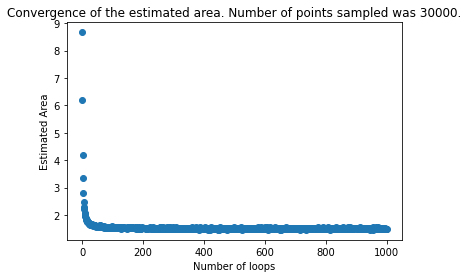

In [60]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 30000.")
plt.savefig("precisionArea.jpg")

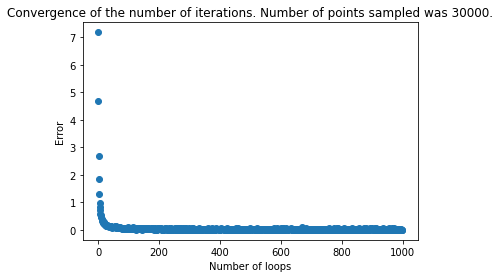

In [61]:
plt.scatter(precisionResult[0], precisionResult[2])
plt.ylabel("Error")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the number of iterations. Number of points sampled was 30000.")
plt.savefig("precisionConvergence.jpg")

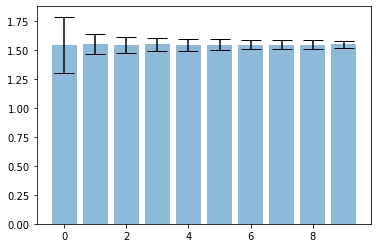

In [59]:
createBars(10, precisionResult)

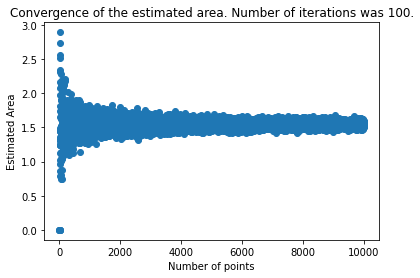

In [62]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.")
plt.savefig("pointsArea.jpg")

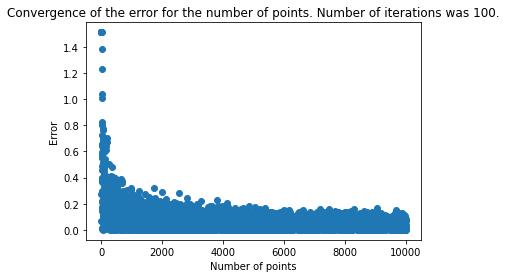

In [63]:
plt.scatter(pointResult[0], pointResult[2])
plt.ylabel("Error")
plt.xlabel("Number of points")
plt.title(f"Convergence of the error for the number of points. Number of iterations was 100.")
plt.savefig("pointsConvergence.jpg")

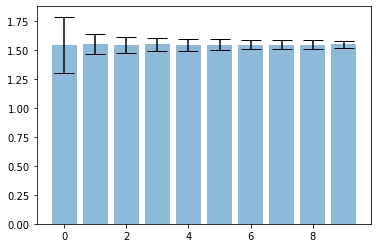

In [64]:
createBars(10, pointResult)

In [65]:
simulator = mendelSim(simStrat = "latin", width = 1000, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.4796799999999999

In [66]:
def monteCarloLatin(precision, width):
    simulator = mendelSim(simStrat = "latin", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()


In [67]:
#test convergence of latin hypercube strategy. This works a little differently, because our input points are dependent on the 
# width of the picture

inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = i, width = 10000)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

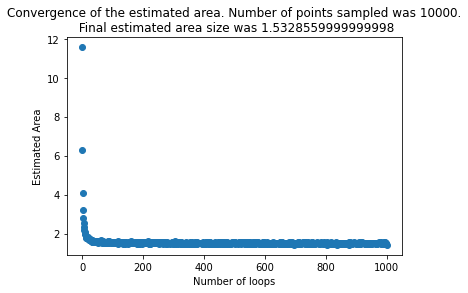

In [68]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was 10000.")
plt.savefig("precisionAreaLatin.jpg")

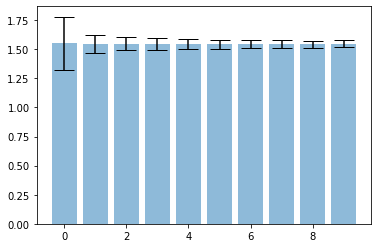

In [70]:
createBars(10, precisionResult)

In [69]:
inputPointSize = 10000
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = 100, width = i+1)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/10000 [00:00<?, ?it/s]

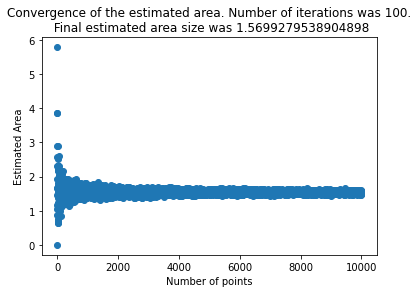

In [25]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 100.")
plt.savefig("pointsAreaLatin.jpg")

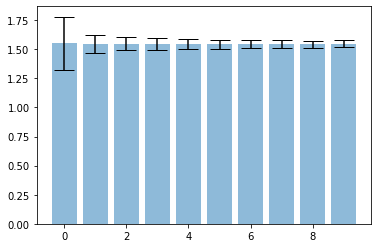

In [71]:
createBars(10, pointResult)

In [75]:
simulator = mendelSim(simStrat = "orthogonal", width = 80**2, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.5533749999999997

In [76]:
def monteCarloOrtho(precision, width):
    simulator = mendelSim(simStrat = "orthogonal", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()

In [77]:
#test convergence of orthogonal latin hypercube strategy. This works a little differently, 
# because our input points are dependent on the square of the width of the picture

inputPrecisionSize = 500
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloOrtho)(precision = i, width = 35**2)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/500 [00:00<?, ?it/s]

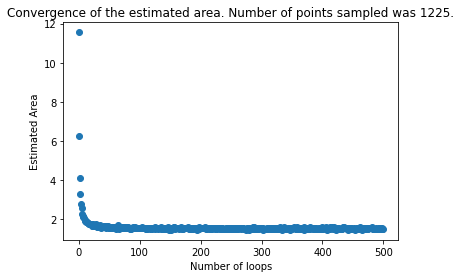

In [78]:
plt.scatter(precisionResult[0], precisionResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of loops")
plt.title(f"Convergence of the estimated area. Number of points sampled was {35**2}.")
plt.savefig("precisionAreaOrtho.jpg")

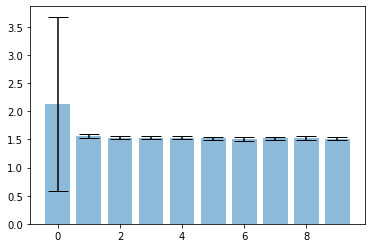

In [81]:
createBars(10, precisionResult)

In [82]:
inputPointSize = 80
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=6)(delayed(monteCarloOrtho)(precision = 500, width = (i+1)**2)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/80 [00:00<?, ?it/s]

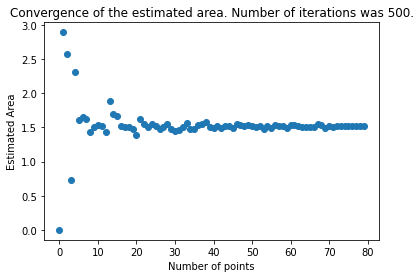

In [83]:
plt.scatter(pointResult[0], pointResult[1])
plt.ylabel("Estimated Area")
plt.xlabel("Number of points")
plt.title(f"Convergence of the estimated area. Number of iterations was 500.")
plt.savefig("pointsAreaOrtho.jpg")

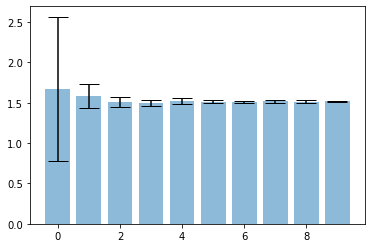

In [84]:
createBars(10, pointResult)

In [86]:
sort = getResults(pointResult)

In [90]:
sort

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        , 27.        , 28.        , 29.        ,
        30.        , 31.        , 32.        , 33.        , 34.        ,
        35.        , 36.        , 37.        , 38.        , 39.        ,
        40.        , 41.        , 42.        , 43.        , 44.        ,
        45.        , 46.        , 47.        , 48.        , 49.        ,
        50.        , 51.        , 52.        , 53.        , 54.        ,
        55.        , 56.        , 57.        , 58.        , 59.        ,
        60.        , 61.        , 62.        , 63.        , 64.        ,
        65.        , 66.        , 67.        , 68. 

In [129]:
def orthogonalFast(num_points):
    major = int(np.sqrt(num_points))
    # intialise the x and y lists
    # the xlist keeps track what minor column has the sample in major cell with major cell i, j
    # the ylist does the same for the minor row
    xlist = np.zeros((major,major), np.int32)
    ylist = np.zeros((major,major), np.int32)
    
    # start with the most simple solution
    m = 0
    for i in range(major):
        for j in range(major):
            xlist[i][j] = m
            ylist[i][j] = m
            m += 1
    # shuffle the lists so that a random solution is obtained
    for i in range(major):
        np.random.shuffle(xlist[i])
        np.random.shuffle(ylist[i])
    return xlist, ylist

In [145]:
major =  2
xlist, ylist = orthogonalFast(major**2)

In [146]:
xlist

array([[0, 1],
       [2, 3]])

In [147]:
ylist

array([[0, 1],
       [3, 2]])

In [148]:
# retrieve the sample coordinates
x=[]
y=[]
for i in range(major):
    for j in range(major):
        x.append(xlist[i][j])
        y.append(ylist[i][j])

In [149]:
print(x)
print(y)

[0, 1, 2, 3]
[0, 1, 3, 2]


In [151]:
n=2
blocks = {(i,j):[(a,b) for a in range(n) for b in range(n)] for i in range(n) for j in range(n)}

In [152]:
for block in blocks:
    print(blocks[block])

[(0, 0), (0, 1), (1, 0), (1, 1)]
[(0, 0), (0, 1), (1, 0), (1, 1)]
[(0, 0), (0, 1), (1, 0), (1, 1)]
[(0, 0), (0, 1), (1, 0), (1, 1)]


In [153]:
block = (0,0)
point = random.choice(blocks[block])
lst_row = [(k1, b) for (k1, b), v in blocks.items() if k1 == block[0]]
lst_col = [(a, k1) for (a, k1), v in blocks.items() if k1 == block[1]]
for col in lst_col:
    blocks[col] = [a for a in blocks[col] if a[1] != point[1]]
for row in lst_row:
    blocks[row] = [a for a in blocks[row] if a[0] != point[0]]

In [155]:
print(lst_row)
print(lst_col)

[(0, 0), (0, 1)]
[(0, 0), (1, 0)]
